http://dspace.univ-tlemcen.dz/bitstream/112/15809/1/Ms.Gbm.Aissaoui%2BHamdouche.pdf

https://iopscience.iop.org/article/10.1088/1742-6596/1376/1/012023/pdf

In [1]:
import numpy as np
from skimage.morphology import erosion, dilation, binary_erosion, opening, closing, white_tophat, reconstruction, black_tophat, skeletonize, convex_hull_image, thin
from skimage.morphology import square, diamond, octagon, rectangle, star, disk, ball
from skimage.filters.rank import entropy, enhance_contrast_percentile
from PIL import Image
from scipy import ndimage as ndi
from skimage.util import img_as_ubyte
import math
from skimage import data, filters
from matplotlib import pyplot as plt
from matplotlib.image import imread
from skimage import io
import os
import cv2

from skimage import exposure
from skimage.morphology import black_tophat,white_tophat, remove_small_objects
import skimage.segmentation as segmentation
from skimage.filters import threshold_isodata, median, gaussian

from skimage import io
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.segmentation import active_contour
from skimage.segmentation import clear_border, chan_vese
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects

In [2]:
DATA_DIR = 'images_IOSTAR/'
# get images list from folder using os.listdir
images = os.listdir(path=DATA_DIR)
images_GT = images[:10]
images_train = images[10:]
# Number of images
print("Number of images: ", len(images))

Number of images:  20


In [3]:
def show_img(image, titre = 'image',cmap='gray'):
    plt.imshow(image, cmap=cmap)
    plt.title(titre)
    plt.axis("off")
    plt.show()


C:\Users\gblna\AppData\Local\Temp\ipykernel_25528\2142829475.py:34: FutureWarning: `max_iter` is a deprecated argument name for `thin`. It will be removed in version 1.0. Please use `max_num_iter` instead.
  GT_skel  = thin(img_GT, max_iter = 15) # On suppose que la demie epaisseur maximum
C:\Users\gblna\AppData\Local\Temp\ipykernel_25528\2142829475.py:35: FutureWarning: `max_iter` is a deprecated argument name for `thin`. It will be removed in version 1.0. Please use `max_num_iter` instead.
  img_out_skel  = thin(img_out, max_iter = 15) # d'un vaisseau est de 15 pixels...


star01_OSC.jpg Accuracy = 0.869979402677652 , Recall = 0.6751248751248752


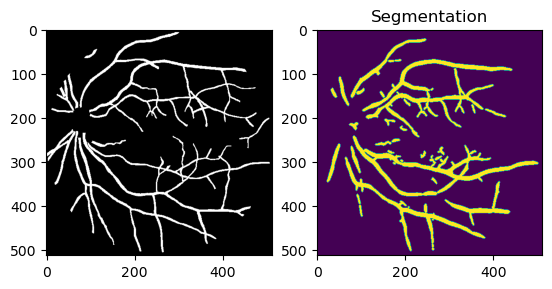

star02_OSC.jpg Accuracy = 0.7647269471799463 , Recall = 0.8310955438801323


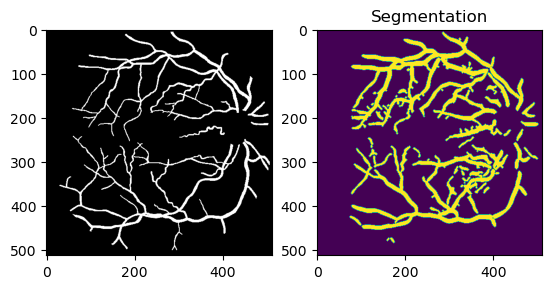

star03_OSN.jpg Accuracy = 0.8875406283856988 , Recall = 0.6574638844301766


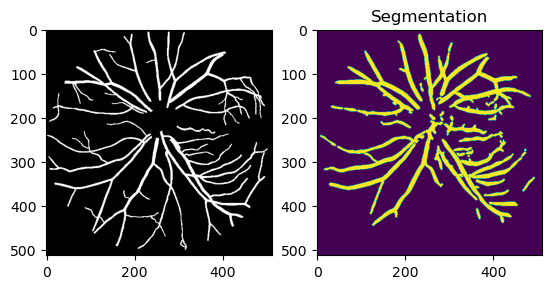

star08_OSN.jpg Accuracy = 0.935417944001635 , Recall = 0.6896188036763597


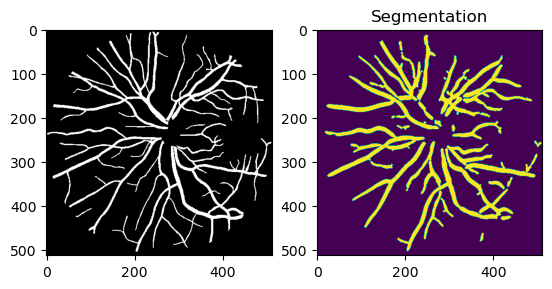

star21_OSC.jpg Accuracy = 0.7546212395795578 , Recall = 0.6663466154584734


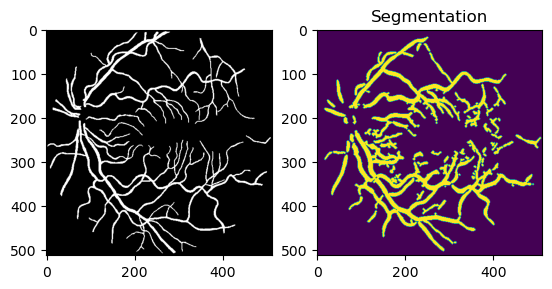

star26_ODC.jpg Accuracy = 0.8425624321389794 , Recall = 0.6487209496739675


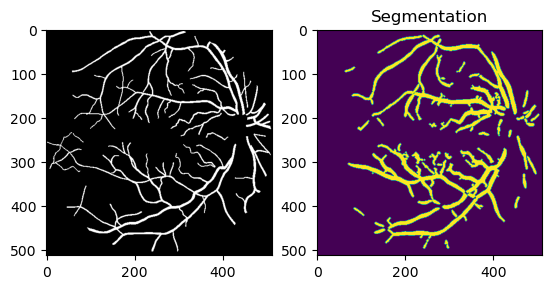

star28_ODN.jpg Accuracy = 0.8659769008662175 , Recall = 0.5972452704945237


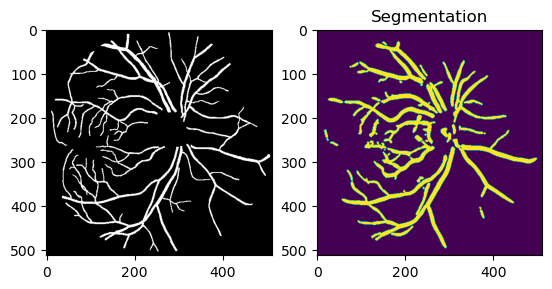

star32_ODC.jpg Accuracy = 0.8480690060772398 , Recall = 0.6606597434331093


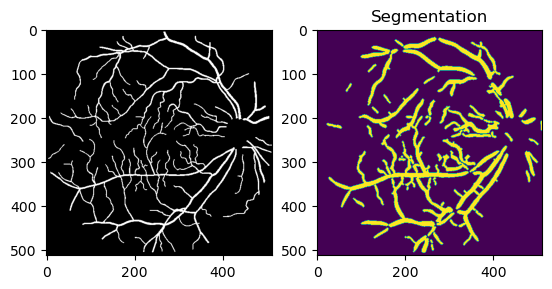

star37_ODN.jpg Accuracy = 0.8609422492401215 , Recall = 0.676956781517626


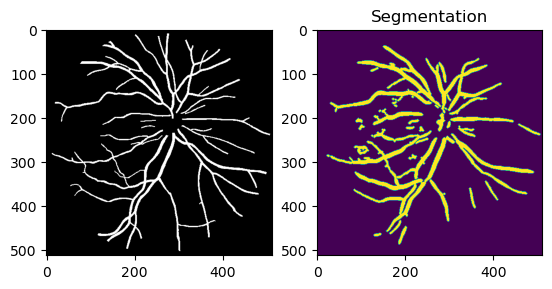

star48_OSN.jpg Accuracy = 0.85272681578286 , Recall = 0.7548387096774194


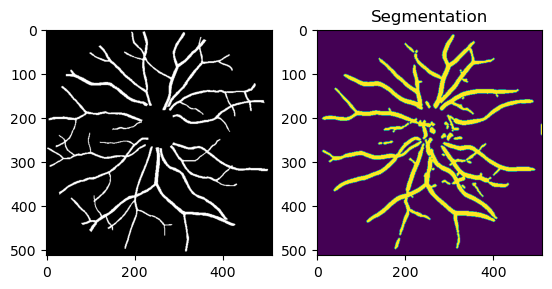

 Moyenne ACCURACY | RECALL  0.8482563565929908 0.6858071177366664
1.534063474329657


In [10]:
def my_segmentation(img):
    gauss = filters.gaussian(img, sigma=1)

    
    img_adapteq = exposure.equalize_adapthist(gauss, clip_limit=0.02)

    img_median = median(img_adapteq, diamond(2))

    struct_elems = [rectangle(2,9), rectangle(9,2), diamond(5)]
    top_hat = []
    for struct_elem in struct_elems:
        top_hat.append(black_tophat(img_median, struct_elem))

    combined_entropy = np.max(top_hat, axis=0)

    final_filter = filters.meijering(combined_entropy, black_ridges=None, sigmas=range(1, 5))
    img_ISODATA = final_filter > 0.18 #0.15



    struct_elems = [rectangle(1,3), rectangle(3,1), diamond(2)]
    dila = []
    for struct_elem in struct_elems:
        dila.append(dilation(img_ISODATA, struct_elem))
    combined_dila = np.max(dila, axis=0)  

    # Remove small objects with area less than 100 pixels
    threshold_area = 100
    cleaned_image = remove_small_objects(combined_dila, min_size=threshold_area)

    return cleaned_image

def evaluate(img_out, img_GT):
    GT_skel  = thin(img_GT, max_iter = 15) # On suppose que la demie epaisseur maximum 
    img_out_skel  = thin(img_out, max_iter = 15) # d'un vaisseau est de 15 pixels...
    TP = np.sum(img_out_skel & img_GT) # Vrais positifs
    FP = np.sum(img_out_skel & ~img_GT) # Faux positifs
    FN = np.sum(GT_skel & ~img_out) # Faux negatifs

    ACCU = TP / (TP + FP) # Precision
    RECALL = TP / (TP + FN) # Rappel
    return ACCU, RECALL, img_out_skel, GT_skel

accu_list = []
recall_list = []

for i in range(len(images_train)):
    img =np.asarray(Image.open(DATA_DIR + images_train[i])).astype(np.uint8)
    # img =  np.asarray(Image.open('./images_IOSTAR/star01_OSC.jpg')).astype(np.uint8)

    img_out = my_segmentation(img)

    #Ouvrir l'image Verite Terrain en booleen
    img_GT =  np.asarray(Image.open(DATA_DIR + images_GT[i])).astype(np.bool_)

    ACCU, RECALL, img_out_skel, GT_skel = evaluate(img_out, img_GT)
    print(images_train[i] , 'Accuracy =', ACCU,', Recall =', RECALL)
    
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(img_GT,cmap = 'gray')
    plt.title('Vérité terrain')
    axarr[1].imshow(img_out)
    plt.title('Segmentation')
    plt.show()

    accu_list.append(ACCU)
    recall_list.append(RECALL)
    
print(" Moyenne ACCURACY | RECALL ",np.array(accu_list).mean(), np.array(recall_list).mean())
print(np.array(accu_list).mean() + np.array(recall_list).mean())

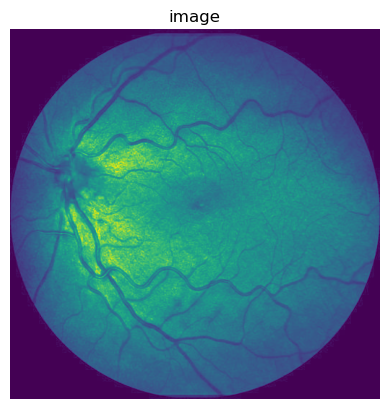

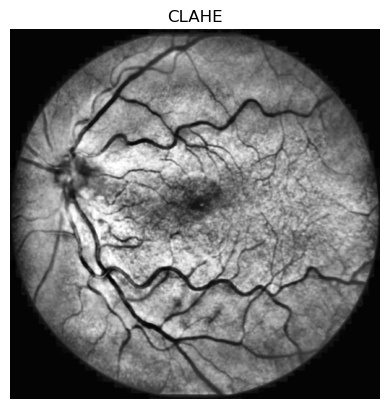

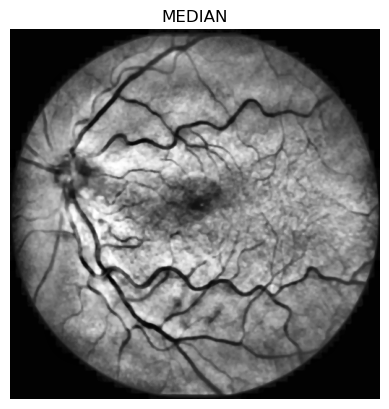

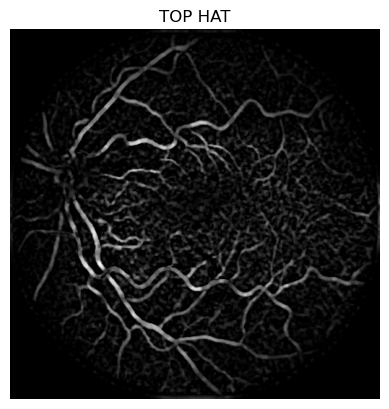

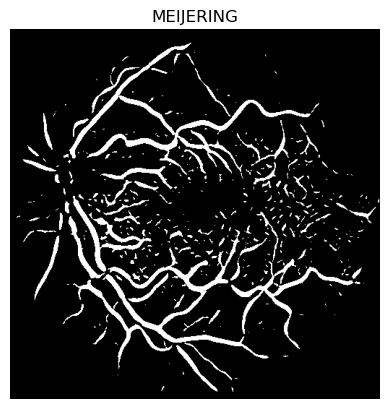

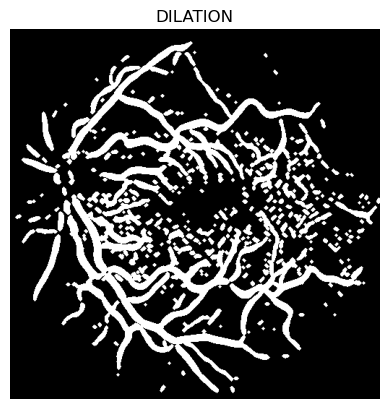

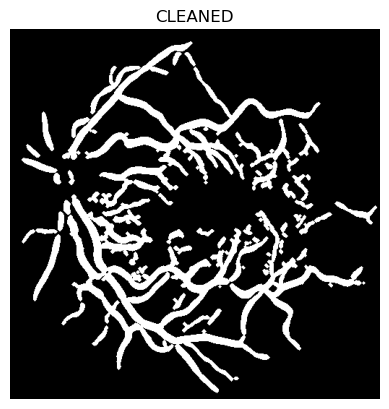

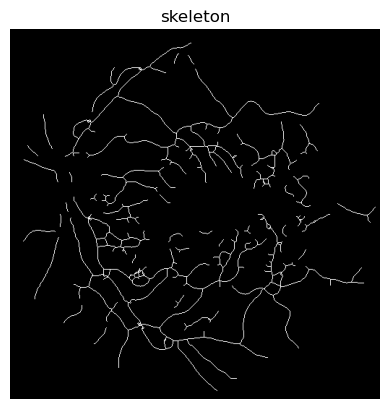

In [11]:
def traitement_1(image):

    show_img(image, titre='image', cmap=None)
    gauss = filters.gaussian(image, sigma=1)
    plt.imsave(os.path.join('output', 'GAUSSIAN.png'), gauss, cmap='gray')
    # # Contrast Limited Adaptive Histogram Equalization (CLAHE).
    img_adapteq = exposure.equalize_adapthist(gauss, clip_limit=0.02)
    show_img(img_adapteq, titre='CLAHE')
    plt.imsave(os.path.join('output', 'CLAHE.png'), img_adapteq, cmap='gray')

    img_median = median(img_adapteq, diamond(2))
    show_img(img_median, titre='MEDIAN')
    plt.imsave(os.path.join('output', 'MEDIAN.png'), img_median, cmap='gray')

    struct_elems = [rectangle(2, 9), rectangle(9, 2), diamond(5)]
    top_hat = []
    for struct_elem in struct_elems:
        top_hat.append(black_tophat(img_median, struct_elem))
    combined_entropy = np.max(top_hat, axis=0)
    show_img(combined_entropy, titre='TOP HAT')
    plt.imsave(os.path.join('output', 'TOP HAT.png'), combined_entropy, cmap='gray')

    final_filter = filters.meijering(combined_entropy, black_ridges=None, sigmas=range(1, 5))
    img_MEIJERING = final_filter > 0.18  
    show_img(img_MEIJERING, titre='MEIJERING')
    plt.imsave(os.path.join('output', 'MEIJERING.png'), img_MEIJERING, cmap='gray')

    struct_elems = [rectangle(1, 3), rectangle(3, 1), diamond(2)]
    dila = []
    for struct_elem in struct_elems:
        dila.append(dilation(img_MEIJERING, struct_elem))
    combined_dila = np.max(dila, axis=0)
    show_img(combined_dila, titre='DILATION')
    plt.imsave(os.path.join('output', 'DILATION.png'), combined_dila, cmap='gray')

    # Remove small objects with area less than 100 pixels
    threshold_area = 100
    cleaned_image = remove_small_objects(combined_dila, min_size=threshold_area)
    show_img(cleaned_image, titre='CLEANED')
    plt.imsave(os.path.join('output', 'CLEANED.png'), cleaned_image, cmap='gray')

    skeleton = skeletonize(cleaned_image)
    show_img(skeleton, titre='skeleton')
    return cleaned_image
    
cleaned_image = traitement_1(io.imread(DATA_DIR + images_train[4]))